<a href="https://colab.research.google.com/github/rahiakela/small-language-models-fine-tuning/blob/main/domain-specific-small-language-models/07-advanced-quantization-techniques/03_bitnet_model_architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BitNet Transformer architecture

BitNet is a scalable 1-bit Transformer architecture designed to tackle the challenges associated with the growing size of large language models, particularly in terms of deployment costs and environmental concerns due to high energy consumption.

It introduces a novel component called BitLinear,
which substitutes traditional linear layers, enabling the training of 1-bit weights from scratch.

Overall, BitNet seems to carry potential for
reduced inference costs and improved performance on downstream tasks,
positioning it as a promising alternative to other quantization methods.

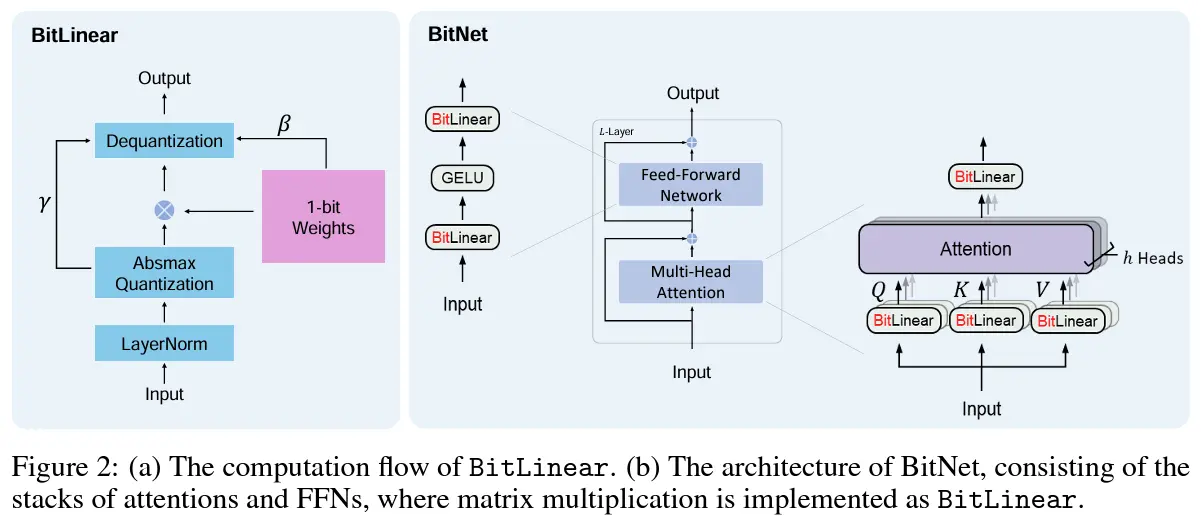

We can notice that the BitNet architecture has the same
layout as for the Transformers. The main difference is about the usage of the
BitLinear instead of matrix multiplication at the attention layers level. This
leads to binarized model weights for the attention (1-bit), while the other
parts of the architecture still use a higher precision (8-bit).

This way we are reducing computational costs, but the precision is preserved for the
input/output embedding because a model based on this architecture still uses
high-precision probabilities to perform sampling.


BitNet could be then a valid alternative to other quantization strategies when
there are computational and sustainability constraints.

## Setup

Install BitNet.

In [ ]:
!pip install bitnet

Import the required dependencies.

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import pipeline
from bitnet import BitNetTransformer
from bitnet import replace_linears_in_hf
from bitnet import BitNetInference

import torch
from torch import nn
from bitnet import replace_linears_in_pytorch_model

## Load model

Let's load BitNet Transformer model.

In [2]:
bitnet = BitNetTransformer(
  num_tokens=20000,
  dim=1024,
  depth=6,
  heads=8,
  ff_mult=4,
)

In [3]:
print(bitnet)

BitNetTransformer(
  (emb): Embedding(20000, 1024)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-5): 6 x BitMGQA(
        (q_proj): BitLinear(in_features=1024, out_features=1024, bias=True)
        (k_proj): BitLinear(in_features=1024, out_features=512, bias=True)
        (v_proj): BitLinear(in_features=1024, out_features=512, bias=True)
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (out_proj): BitLinear(in_features=512, out_features=1024, bias=True)
      )
    )
    (ffn_layers): ModuleList(
      (0-5): 6 x BitFeedForward(
        (ff): Sequential(
          (0): Sequential(
            (0): BitLinear(in_features=1024, out_features=4096, bias=True)
            (1): SiLU()
          )
          (1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
          (2): Dropout(p=0.1, inplace=False)
          (3): BitLinear(in_features=4096, out_features=1024, bias=True)
        )
      )
    )
  )
  (to_logits): Sequential(
    (0): R

Let’s try to use it with ProtGPT2.

In [ ]:
model_id = "nferruz/ProtGPT2"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id)

Then we delegate the BitNet API to replace the linear layers for which a
BitNet implementation is available.

In [5]:
replace_linears_in_hf(model)

We can notice that the head linear layers have been replaced.

In [6]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1280)
    (wpe): Embedding(1024, 1280)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-35): 36 x GPT2Block(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3840, nx=1280)
          (c_proj): Conv1D(nf=1280, nx=1280)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=5120, nx=1280)
          (c_proj): Conv1D(nf=1280, nx=5120)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): BitLinear(in_features=1280, out_features=50257, bias=False)
)


## Make Inference

Inference can now happen the usual way with the Transformer API, also
using a pipeline.

In [7]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer
)

In [8]:
sequences = pipe(
    "<|endoftext|>",
    max_length=100,
    do_sample=True,
    top_k=950,
    repetition_penalty=1.2,
    num_return_sequences=10,
    eos_token_id=0
)

In [9]:
print(sequences)

[{'generated_text': '<|endoftext|>KGSRTGNGDITGCPTPKYFSQIPSPGTNGQHAFPGTNQEVPWDTIQKGPIVTWSLGFNHLNLTNAYAFTLKLRFKDQLSFCPLGDMQEKSIIQQGLDIGTGISIMRMARESQPSFDNFVLRNIVCTRVAYTLKFNYPEEKNFEGDIYDCLF�KSTQKYKKMLATMAGGKGRKFVPSIHSIFPFLEDIFNYNEIFMKIEICVGTFAAKLHQDLNKQVRGRVLGMQYNITRGLAPPPPELNRALLPKGSYMQELGESLFPGPGLGVRHEVGMESGRTVDRLAQLQPVYKDGVISIINREQTLWRNLTTGLWVESTSRFNQVEMTLSPPPNIPVQFPEDTIHNLVSFGGRIRFLSHPTQVEMSAPFHRLARGGGSQKAWANPVIDTGGGVAIQTQSPNNIHGRNFSSGKSTLHGKSITAHVTQPMSPEVCLLSPVTYGFLCSELTVMSQHQHTEGETDKDHLQGYLERYKVRAADFAVAEAPITQYVKMPLPTLGFVDLLRDDQSLGIVKLPPKLVISQTFAVRDALRLVNEKFEEETTVTNALGADFMMF�NPCGVRTVGAYLQTAAYDVEFKLDHWDTAKGVINEKSPINEQEWLSEYAVSTGCNHLLTALAPVEIKNKQLTDTKLLDDTRVVKHMIVNMMADSGARGSYPADFLHVGILEELGLGAEVLRQDDARVFVIYAHSFIHQLVYQQKTNEQRANFYSE�GKSMCGEKILTLKALYAQLRKVLHLFLRDITLGFVDLLRDDTYFSNNSFTQKGRRLEAEFKDNIKKTKAEQNFIYGRLALLSKTTVPPL<DSIDQKGGDLQQYKCEEHRVTYTGTERHDFLPVELLQSQSGPMEEPKVIGLKSELASLIQRALKFANFPINSMALSRPFTTNRIKRAVSQYGGDGETYLSWQKFHRLMPLLALRAGVKTMFESNGGHWLKGVNSPVRAFIQSVQNNAQVQVVGASPVAHRTDEPMMTFVED

BitNet package also provides a drop-in replacement for PyTorch
models, as follows:

In [10]:
model = nn.Sequential(
  nn.Linear(10, 20),
  nn.ReLU(),
  nn.Linear(20, 30),
)

In [11]:
replace_linears_in_pytorch_model(model)

In [12]:
print(model)

Sequential(
  (0): BitLinear(in_features=10, out_features=20, bias=True)
  (1): ReLU()
  (2): BitLinear(in_features=20, out_features=30, bias=True)
)


In [15]:
torch.save(model, "model_checkpoint.pth")

In [19]:
bitnet = BitNetInference()
bitnet.load_model("model_checkpoint.pth")
output_str = bitnet.generate("The dog jumped over the ", 512)

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torch.nn.modules.container.Sequential was not an allowed global by default. Please use `torch.serialization.add_safe_globals([torch.nn.modules.container.Sequential])` or the `torch.serialization.safe_globals([torch.nn.modules.container.Sequential])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.